In [ ]:
import os
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix
import time
import cv2
from torchvision.transforms import Lambda
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
import copy
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
data_dir = "/mnt/c/Users/Shiva Subhan S/Downloads/SOCOFing/SOCOFing"
print(data_dir)

/mnt/c/Users/Shiva Subhan S/Downloads/SOCOFing/SOCOFing


In [ ]:

def setup_data_directories():
    """Setup train/validation split for Real and Fake fingerprint dataset"""
    import shutil

    train_dir_real = os.path.join(data_dir, "train", "Real")
    val_dir_real = os.path.join(data_dir, "val", "Real")
    train_dir_fake = os.path.join(data_dir, "train", ""
    ""
    ""
    "")
    val_dir_fake = os.path.join(data_dir, "val", "Fake")

    # Create directories if they don't exist
    os.makedirs(train_dir_real, exist_ok=True)
    os.makedirs(val_dir_real, exist_ok=True)
    os.makedirs(train_dir_fake, exist_ok=True)
    os.makedirs(val_dir_fake, exist_ok=True)

    # Split Real data into train and validation sets (80-20 split)
    src_path_real = os.path.join(data_dir, "Real")
    files_real = os.listdir(src_path_real)
    split_idx_real = int(len(files_real) * 0.8)

    # Copy Real files to train and validation directories
    for f in files_real[:split_idx_real]:
        src_file = os.path.join(src_path_real, f)
        dst_file = os.path.join(train_dir_real, f)
        if not os.path.exists(dst_file):
            shutil.copy2(src_file, dst_file)

    for f in files_real[split_idx_real:]:
        src_file = os.path.join(src_path_real, f)
        dst_file = os.path.join(val_dir_real, f)
        if not os.path.exists(dst_file):
            shutil.copy2(src_file, dst_file)

    # Split Altered data into train and validation sets (80-20 split)
    src_path_fake = os.path.join(data_dir, "Altered", "Altered-Hard")
    files_fake = os.listdir(src_path_fake)
    split_idx_fake = int(len(files_fake) * 0.8)

    # Copy Fake files to train and validation directories
    for f in files_fake[:split_idx_fake]:
        src_file = os.path.join(src_path_fake, f)
        dst_file = os.path.join(train_dir_fake, f)
        if not os.path.exists(dst_file):
            shutil.copy2(src_file, dst_file)

    for f in files_fake[split_idx_fake:]:
        src_file = os.path.join(src_path_fake, f)
        dst_file = os.path.join(val_dir_fake, f)
        if not os.path.exists(dst_file):
            shutil.copy2(src_file, dst_file)

# Setup data directories before loading datasets
setup_data_directories()

CUDA is available. Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Successfully initialized GPU device for PennyLane
Using device: cuda:0


/home/shiva_subhan_s/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training started:

Images processed: 0
Actual labels: tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Gradient Norm: 76612.7812
Quantum Time: 1.8092s
Phase: train Epoch: 1/5 Iter: 25/507 Batch time: 5.9223
Images processed: 800
Actual labels: tensor([0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted labels: tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Gradient Norm: 36196.9688
Quantum Time: 2.0665s
Phase: train Epoch: 1/5 Iter: 50/507 Batch time: 5.9888
Images processed: 1600
Actual labels: tensor([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0

TypeError: max() received an invalid combination of arguments - got (tuple, int), but expected one of:
 * (Tensor input, *, Tensor out = None)
 * (Tensor input, Tensor other, *, Tensor out = None)
 * (Tensor input, int dim, bool keepdim = False, *, tuple of Tensors out = None)
 * (Tensor input, name dim, bool keepdim = False, *, tuple of Tensors out = None)


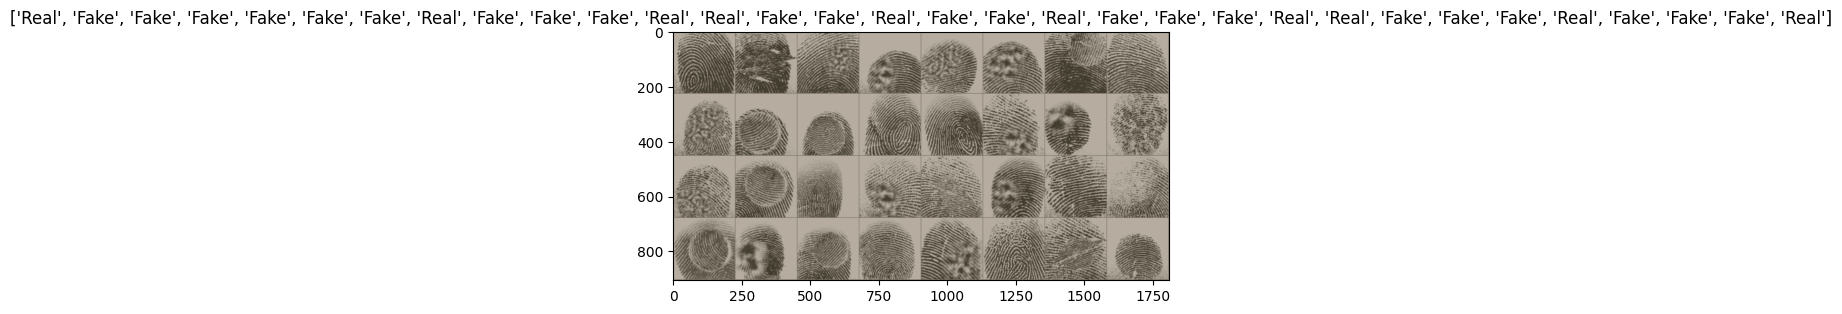

<Figure size 640x480 with 0 Axes>

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 32             # Increased batch size
num_epochs = 5              # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01               # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

#data_dir = r"C:\Users\Shiva Subhan S\Downloads\SOCOFing\SOCOFing"
# Convert Windows path to WSL path


def apply_clahe(img):
    img = np.array(img)  # Convert to numpy array
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert back to RGB
    return Image.fromarray(img)

# Modify data transforms for fingerprint images
data_transforms = {
    "train": transforms.Compose([
        Lambda(apply_clahe),  # Apply CLAHE
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # Normalize grayscale images
    ]),
    "val": transforms.Compose([
        Lambda(apply_clahe),  # Apply CLAHE
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # Normalize grayscale images
    ]),
}

# Load datasets
image_datasets = {
    "train": datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"]),
    "val": datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms["val"]),
}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

# Initialize dataloader with more workers
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
    for x in ["train", "val"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Device setup
if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU")

# PennyLane device setup
try:
    dev = qml.device("lightning.gpu", wires=n_qubits)
    print("Successfully initialized GPU device for PennyLane")
except:
    print("GPU device not available, falling back to CPU")
    dev = qml.device("default.qubit", wires=n_qubits)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)
        qml.RY(element * 0.5, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, n_qubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    Variational Quantum Circuit with optimized measurements.
    """
    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Use Pauli-Z for half of qubits and Pauli-X for the rest
    exp_vals = [qml.expval(qml.PauliZ(i)) if i % 2 == 0 else qml.expval(qml.PauliX(i))
                for i in range(n_qubits)]
    return tuple(exp_vals)

class DressedQuantumNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pre_net1 = nn.Linear(1280, 128)  # Input from EfficientNet: 1280 features
        self.pre_net2 = nn.Linear(128, n_qubits)  # Reduce to n_qubits (4)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)  # Final output: 2 classes

    def forward(self, input_features):
        # First reduction with ReLU activation
        pre_out = torch.relu(self.pre_net1(input_features))
        # Second reduction
        pre_out = self.pre_net2(pre_out)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit
        q_out = torch.Tensor(0, n_qubits).to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # Final output
        final_output = self.post_net(q_out)
        return final_output, q_in  # Return both final output and quantum input

weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
model_hybrid = torchvision.models.efficientnet_b0(weights=weights)

for param in model_hybrid.parameters():
    param.requires_grad = False

# Notice that model_hybrid.classifier is the last layer of EfficientNet
model_hybrid.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    DressedQuantumNet()
)

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

# Use label smoothing in CrossEntropyLoss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer_hybrid = optim.Adam(model_hybrid.classifier.parameters(), lr=step)

# Modify learning rate scheduler for better convergence
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_hybrid, mode='min', factor=0.2, patience=3, verbose=True)

scaler = torch.amp.GradScaler()  # For mixed precision training

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0
    print("Training started:")

    metrics = {
        'train': {'loss': [], 'acc': [], 'precision': [], 'recall': [], 'f1': [], 'auc': [], 'lr': []},
        'val': {'loss': [], 'acc': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
    }

    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            all_probs = []

            n_batches = dataset_sizes[phase] // batch_size
            it = 0

            for inputs, labels in dataloaders[phase]:
                batch_start = time.time()
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                        outputs, q_in = model(inputs)
                        probs = F.softmax(outputs, dim=1)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        scaler.step(optimizer)
                        scaler.update()

                # Collect predictions, labels, and probabilities
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                all_preds.extend(preds.detach().cpu().numpy())
                all_labels.extend(labels.detach().cpu().numpy())
                all_probs.extend(probs[:, 1].detach().cpu().numpy())

                # Quantum circuit timing (optional)
                quantum_start = time.time()
                q_in_fp32 = q_in.to(torch.float32)
                for elem in q_in_fp32:
                    quantum_net(elem, model.classifier[1].q_params)
                quantum_time = time.time() - quantum_start

                # Batch-level logging
                if it % 25 == 0:
                    print(f"\nImages processed: {(epoch * n_batches + it) * batch_size}")
                    print(f"Actual labels: {labels}")
                    print(f"Predicted labels: {preds}")
                    print(f"Gradient Norm: {grad_norm:.4f}")
                    print(f"Quantum Time: {quantum_time:.4f}s")

                print(
                    f"Phase: {phase} Epoch: {epoch + 1}/{num_epochs} Iter: {it + 1}/{n_batches + 1} Batch time: {time.time() - batch_start:.4f}",
                    end="\r",
                    flush=True,
                )
                it += 1

            # Epoch-level metrics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
            auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0.0
            conf_matrix = confusion_matrix(all_labels, all_preds)

            # Per-class accuracy
            class_acc = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
            # Prediction confidence for correct predictions
            confidences = [
                p if all_preds[i] == 1 else 1 - p
                for i, (p, l, pred) in enumerate(zip(all_probs, all_labels, all_preds))
                if pred == l
            ]
            pred_confidence = np.mean(confidences) if confidences else 0.0

            # Log metrics
            metrics[phase]['loss'].append(epoch_loss)
            metrics[phase]['acc'].append(epoch_acc)
            metrics[phase]['precision'].append(precision)
            metrics[phase]['recall'].append(recall)
            metrics[phase]['f1'].append(f1)
            metrics[phase]['auc'].append(auc)
            if phase == "train":
                metrics[phase]['lr'].append(optimizer.param_groups[0]['lr'])

            print(f"Phase: {phase} Epoch: {epoch + 1}/{num_epochs} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
            print(f"Confusion Matrix:\n{conf_matrix}")
            print(f"Per-Class Accuracy: Real: {class_acc[1]:.4f}, Fake: {class_acc[0]:.4f}")
            print(f"Prediction Confidence: {pred_confidence:.4f}")

            # Update best model and scheduler
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train":
                scheduler.step(epoch_loss)

        # Save checkpoint
        epoch_save_path = f'/mnt/d/msme/model_epoch_{epoch + 1}.pth'
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'metrics': metrics,
        }, epoch_save_path)
        print(f"Saved model checkpoint to {epoch_save_path}")

    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(f"Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best test loss: {best_loss:.4f} | Best test accuracy: {best_acc:.4f}")
    return model, metrics

def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

if __name__ == '__main__':
    # Set multiprocessing start method for Windows
    if os.name == 'nt':
        import multiprocessing
        multiprocessing.set_start_method('spawn')

    # Get a batch of training data
    inputs, classes = next(iter(dataloaders["val"]))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[class_names[x] for x in classes])

    model_hybrid,metrics = train_model(
        model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
    )

    visualize_model(model_hybrid, num_images=batch_size)
    plt.show()

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 32             # Increased batch size
num_epochs = 5              # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01               # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

#data_dir = r"C:\Users\Shiva Subhan S\Downloads\SOCOFing\SOCOFing"
# Convert Windows path to WSL path


def apply_clahe(img):
    img = np.array(img)  # Convert to numpy array
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert back to RGB
    return Image.fromarray(img)

# Modify data transforms for fingerprint images
data_transforms = {
    "train": transforms.Compose([
        Lambda(apply_clahe),  # Apply CLAHE
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # Normalize grayscale images
    ]),
    "val": transforms.Compose([
        Lambda(apply_clahe),  # Apply CLAHE
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # Normalize grayscale images
    ]),
}

# Load datasets
image_datasets = {
    "train": datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"]),
    "val": datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms["val"]),
}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

# Initialize dataloader with more workers
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
    for x in ["train", "val"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Device setup
if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU")

# PennyLane device setup
try:
    dev = qml.device("lightning.gpu", wires=n_qubits)
    print("Successfully initialized GPU device for PennyLane")
except:
    print("GPU device not available, falling back to CPU")
    dev = qml.device("default.qubit", wires=n_qubits)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)
        qml.RY(element * 0.5, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, n_qubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    Variational Quantum Circuit with optimized measurements.
    """
    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Use Pauli-Z for half of qubits and Pauli-X for the rest
    exp_vals = [qml.expval(qml.PauliZ(i)) if i % 2 == 0 else qml.expval(qml.PauliX(i))
                for i in range(n_qubits)]
    return tuple(exp_vals)

class DressedQuantumNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pre_net1 = nn.Linear(1280, 128)  # Input from EfficientNet: 1280 features
        self.pre_net2 = nn.Linear(128, n_qubits)  # Reduce to n_qubits (4)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)  # Final output: 2 classes

    def forward(self, input_features):
        # First reduction with ReLU activation
        pre_out = torch.relu(self.pre_net1(input_features))
        # Second reduction
        pre_out = self.pre_net2(pre_out)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit
        q_out = torch.Tensor(0, n_qubits).to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # Final output
        final_output = self.post_net(q_out)
        return final_output, q_in  # Return both final output and quantum input

weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
model_hybrid = torchvision.models.efficientnet_b0(weights=weights)

for param in model_hybrid.parameters():
    param.requires_grad = False

# Notice that model_hybrid.classifier is the last layer of EfficientNet
model_hybrid.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    DressedQuantumNet()
)

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

# Use label smoothing in CrossEntropyLoss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer_hybrid = optim.Adam(model_hybrid.classifier.parameters(), lr=step)

# Modify learning rate scheduler for better convergence
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_hybrid, mode='min', factor=0.2, patience=3, verbose=True)

scaler = torch.amp.GradScaler()  # For mixed precision training

def train_model(model, criterion, optimizer, scheduler, num_epochs):l
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0
    print("Training started:")

    metrics = {
        'train': {'loss': [], 'acc': [], 'precision': [], 'recall': [], 'f1': [], 'auc': [], 'lr': []},
        'val': {'loss': [], 'acc': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
    }

    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            all_probs = []

            n_batches = dataset_sizes[phase] // batch_size
            it = 0

            for inputs, labels in dataloaders[phase]:
                batch_start = time.time()
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                        outputs, q_in = model(inputs)
                        probs = F.softmax(outputs, dim=1)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        scaler.step(optimizer)
                        scaler.update()

                # Collect predictions, labels, and probabilities
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                all_preds.extend(preds.detach().cpu().numpy())
                all_labels.extend(labels.detach().cpu().numpy())
                all_probs.extend(probs[:, 1].detach().cpu().numpy())

                # Quantum circuit timing (optional)
                quantum_start = time.time()
                q_in_fp32 = q_in.to(torch.float32)
                for elem in q_in_fp32:
                    quantum_net(elem, model.classifier[1].q_params)
                quantum_time = time.time() - quantum_start

                # Batch-level logging
                if it % 25 == 0:
                    print(f"\nImages processed: {(epoch * n_batches + it) * batch_size}")
                    print(f"Actual labels: {labels}")
                    print(f"Predicted labels: {preds}")
                    print(f"Gradient Norm: {grad_norm:.4f}")
                    print(f"Quantum Time: {quantum_time:.4f}s")

                print(
                    f"Phase: {phase} Epoch: {epoch + 1}/{num_epochs} Iter: {it + 1}/{n_batches + 1} Batch time: {time.time() - batch_start:.4f}",
                    end="\r",
                    flush=True,
                )
                it += 1

            # Epoch-level metrics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
            auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0.0
            conf_matrix = confusion_matrix(all_labels, all_preds)

            # Per-class accuracy
            class_acc = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
            # Prediction confidence for correct predictions
            confidences = [
                p if all_preds[i] == 1 else 1 - p
                for i, (p, l, pred) in enumerate(zip(all_probs, all_labels, all_preds))
                if pred == l
            ]
            pred_confidence = np.mean(confidences) if confidences else 0.0

            # Log metrics
            metrics[phase]['loss'].append(epoch_loss)
            metrics[phase]['acc'].append(epoch_acc)
            metrics[phase]['precision'].append(precision)
            metrics[phase]['recall'].append(recall)
            metrics[phase]['f1'].append(f1)
            metrics[phase]['auc'].append(auc)
            if phase == "train":
                metrics[phase]['lr'].append(optimizer.param_groups[0]['lr'])

            print(f"Phase: {phase} Epoch: {epoch + 1}/{num_epochs} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
            print(f"Confusion Matrix:\n{conf_matrix}")
            print(f"Per-Class Accuracy: Real: {class_acc[1]:.4f}, Fake: {class_acc[0]:.4f}")
            print(f"Prediction Confidence: {pred_confidence:.4f}")

            # Update best model and scheduler
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train":
                scheduler.step(epoch_loss)

        # Save checkpoint
        epoch_save_path = f'/mnt/d/msme/model_epoch_{epoch + 1}.pth'
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'metrics': metrics,
        }, epoch_save_path)
        print(f"Saved model checkpoint to {epoch_save_path}")

    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(f"Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best test loss: {best_loss:.4f} | Best test accuracy: {best_acc:.4f}")
    return model, metrics

def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

if __name__ == '__main__':
    # Set multiprocessing start method for Windows
    if os.name == 'nt':
        import multiprocessing
        multiprocessing.set_start_method('spawn')

    # Get a batch of training data
    inputs, classes = next(iter(dataloaders["val"]))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[class_names[x] for x in classes])

    model_hybrid,metrics = train_model(
        model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
    )

    visualize_model(model_hybrid, num_images=batch_size)
    plt.show()

CUDA is available. Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Successfully initialized GPU device for PennyLane
Using device: cuda:0


/home/shiva_subhan_s/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training started:

Images processed: 0
Actual labels: tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Gradient Norm: 76612.7812
Quantum Time: 1.8092s
Phase: train Epoch: 1/5 Iter: 25/507 Batch time: 5.9223
Images processed: 800
Actual labels: tensor([0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted labels: tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Gradient Norm: 36196.9688
Quantum Time: 2.0665s
Phase: train Epoch: 1/5 Iter: 50/507 Batch time: 5.9888
Images processed: 1600
Actual labels: tensor([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0